In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt


In [2]:
class Sampling(Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = Input(shape =(28, 28, 1))
x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)
x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Flatten()(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [4]:
latent_inputs = keras.Input(shape =(latent_dim, ))
x = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fmnist_images = np.concatenate([x_train, x_test], axis = 0)
# expand dimension to add  a color map dimension
fmnist_images = np.expand_dims(fmnist_images, -1).astype("float32") / 255

# compile and train the model
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(fmnist_images, epochs = 100, batch_size = 64)

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/100
1094/1094 [==============================] - 20s 7ms/step - loss: 303.4318 - reconstruction_loss: 298.6646 - kl_loss: 4.7673
Epoch 2/100
1094/1094 [==============================] - 9s 8ms/step - loss: 275.2633 - reconstruction_loss: 271.4165 - kl_loss: 3.8468
Epoch 3/100
1094/1094 [==============================] - 7s 6ms/step - loss: 268.9171 - reconstruction_loss: 265.3188 - kl_loss: 3.5983
Epoch 4/100
1094/1094 [==============================] - 12s 11ms/step - loss: 266.0405 - reconstruction_loss: 262.4980 - kl_loss: 3.5426
Epoch 5/100
1094/1094 [==============================] - 8s 7ms/step - loss: 264.2102 - reconstruction_loss: 260.6567 - kl_loss: 3.5535
Epoch 6/100
1094/1094 [==============================] - 7s 6ms/step - loss: 262.8436 - reconstruction_loss: 259.2812 - kl_loss: 3.5624
Epoch 7/100
1094/1094 [==============================] - 6s 6ms/step - loss: 261.8196 - reconstruction_loss: 258.2467 

In [ ]:

def plot_latent(encoder, decoder):
    # display a n * n 2D manifold of images
    n = 10
    img_dim = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((img_dim * n, img_dim * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of images classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            images = x_decoded[0].reshape(img_dim, img_dim)
            figure[
                i * img_dim : (i + 1) * img_dim,
                j * img_dim : (j + 1) * img_dim,
            ] = images

    plt.figure(figsize =(figsize, figsize))
    start_range = img_dim // 2
    end_range = n * img_dim + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_dim)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap ="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

1875/1875 [==============================] - 4s 2ms/step


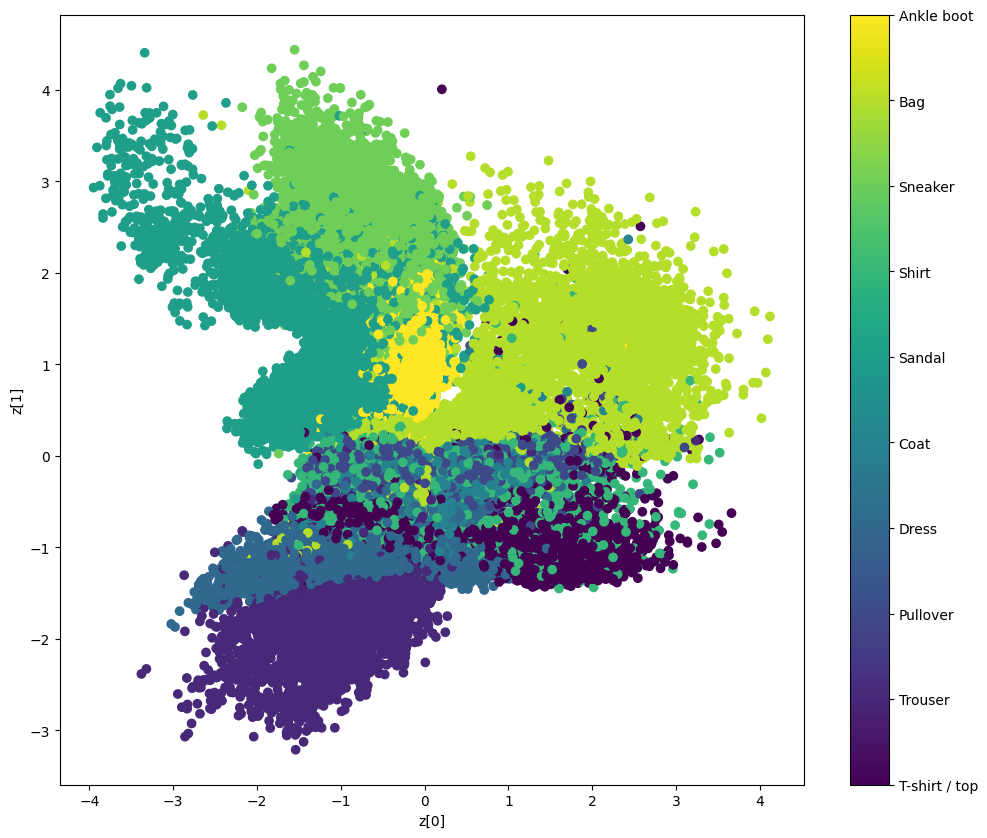

In [8]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(10))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


labels = {0    :"T-shirt / top",
1:    "Trouser",
2:    "Pullover",
3:    "Dress",
4:    "Coat",
5:    "Sandal",
6:    "Shirt",
7:    "Sneaker",
8:    "Bag",
9:    "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)